In [1]:
import pandas as pd
import requests
import spacy
import spark
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.express as px

from bs4 import BeautifulSoup
from collections import Counter, OrderedDict

In [2]:
from pyspark.ml.feature import Word2Vec
from pyspark import SparkContext
sc = SparkContext("local[*]", "temp")
print(sc.version)
from pyspark.sql import SparkSession



3.0.1


In [3]:
# Open dataset of of whiskey reviews.

df = pd.read_csv('../Data/scotch_review.csv')

In [4]:
# Create a new column with the fixed description
df['fixed'] = df.description

In [5]:
df['fixed'] = df['fixed'].str.replace(',', '')
df['fixed'] = df['fixed'].str.replace('.', '')
df['fixed'] = df['fixed'].str.replace('\(', '')
df['fixed'] = df['fixed'].str.replace('\)', '')
df['fixed'] = df['fixed'].str.lower()

In [6]:
# Text I created with the most common words that are not flavours.

f = open('../Data/NotFlavours.txt', 'r')
not_flavours = f.read().splitlines()
f.close()

In [7]:
# List of flavours (most common words from previous analysis that are flavours).

f = open('../Data/Flavours.txt', 'r')
flavours = f.read().splitlines()
f.close()

In [8]:
# Scrape website with whiskey review sto feed into word2vec.

response = requests.get('https://802spirits.com/descriptions/whiskey-descriptions')
soup = BeautifulSoup(response.text, 'lxml')
a = soup.findAll('div', attrs={'class':'field-item even'})

In [9]:
name = []
description = []
for div in a:
    for n in div.findAll('h4'):
        name.append(n.get_text())
    for d in div.findAll('p'):
        description.append(d.get_text())

In [10]:
df2 = pd.DataFrame({'Name': name, 'Desc': description[:-2]})

In [11]:
# Second website with whiskey reviews.

response2 = requests.get('https://www.whiskyadvocate.com/ratings-reviews/?search=&submit=&brand_id=0&rating=0&price=0&category=0&styles_id=0&issue_id=109')
soup2 = BeautifulSoup(response2.text, 'lxml')
a2 = soup2.findAll('div', attrs={'class':'review-text'})

In [12]:
description2 = []
for div in a2:
    for d in div.findAll('span'):
        description2.append(d.get_text())

In [13]:
df3 = pd.DataFrame({'Desc': description2})

In [14]:
# delete reviews with less than 5 characters (get rid of some bad data)

In [15]:
df3['Len'] = 0
for i in range(len(df3)):
    df3['Len'].iloc[i] = len(df3.Desc.str.split(' ').iloc[i])

/Users/daniela/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [16]:
df3.Desc = df3.Desc.str.lower()
df3.Desc = df3.Desc.str.replace(',', '')
df3.Desc = df3.Desc.str.replace('.', '')
df3.Desc = df3.Desc.str.replace('\(', '')
df3.Desc = df3.Desc.str.replace('\)', '')
df3.Desc = df3.Desc.str.lower()

In [17]:
nlp = spacy.load('en_core_web_sm')

In [18]:
doc = [] # This will contain all the text.
for i in range(len(df)):
    doc += nlp(df['fixed'][i])

In [19]:
for i in range(len(df2)):
    doc += nlp(df2.Desc[i])

In [20]:
for i in range(len(df3)):
    doc += nlp(df3.Desc[i])

In [21]:
words = [token.text for token in doc if token.is_stop != True and token.is_punct != True and (token.pos_ != "VERB")]

In [22]:
new_words = [word for word in words if word not in not_flavours]

In [23]:
spark = SparkSession\
        .builder\
        .appName("Word2VecExample")\
        .getOrCreate()

In [24]:
documentDF = spark.createDataFrame(
        [list([new_words])], ["text"])

In [25]:
word2Vec = Word2Vec(vectorSize=70, minCount=25, inputCol="text", outputCol="result", seed=10, stepSize=0.02, maxIter=3)
model = word2Vec.fit(documentDF)

In [26]:
result = model.transform(documentDF)

In [27]:
model.findSynonyms('peat',10).show()

+---------+------------------+
|     word|        similarity|
+---------+------------------+
|    smoky|0.7739993929862976|
|    brine|0.7730938196182251|
|  seaweed|0.7717320322990417|
|medicinal|0.7657656669616699|
|      tar|0.7592146992683411|
|     kiln|0.7584577798843384|
|  bonfire|0.7448513507843018|
|    tarry|0.7356356382369995|
|     coal|0.7289133667945862|
|     fish|0.7256588935852051|
+---------+------------------+



In [28]:
f = []
s = []
v = []

for flavour in flavours:
    syn = model.findSynonymsArray(flavour,10)
    for i in range(len(syn)):
        f.append(flavour)
        s.append(syn[i][0])
        v.append(syn[i][1])

In [29]:
df_flavour = pd.DataFrame({'flavour':f, 'synonym':s, 'value': v})

In [30]:
# Remove synonyms already listed as flavours
df_flavour = df_flavour[~df_flavour['synonym'].isin(flavours)].reset_index(drop=True)

In [31]:
df_flavour[df_flavour['flavour']=='smooth']

,flavour,synonym,value
218,smooth,butterscotch,0.811743
219,smooth,silky,0.785055
220,smooth,sticky,0.735108
221,smooth,sugar,0.720782
222,smooth,warm,0.717077
223,smooth,custard,0.713027
224,smooth,nougat,0.696473


In [32]:
# for a repeated synonym, leave the highest value/
syns = df_flavour['synonym'].unique()

for syn in syns:
    sted = df_flavour[df_flavour['synonym']==syn].sort_values('value', ascending=False)[1:]
    df_flavour = df_flavour.drop(index = sted.index)

In [33]:
df_flavour = df_flavour.reset_index(drop=True)

In [34]:
df['tags'] = ''

for i in range(len(df)):
    dc = nlp(df['description'][i])
    df['tags'].iloc[i] = str([token.text for token in dc if token.text in flavours or token.text in list(df_flavour['synonym'])])[1:-1]

/Users/daniela/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [35]:
for index, row in df_flavour.iterrows():
    #print(row['synonym'], row['flavour'])
    df['tags'] = df['tags'].str.replace(str(row['synonym']), str(row['flavour']))

In [36]:
df.price = df.price.str.extract('(\d+)')

In [37]:
df.to_csv('../Data/Reviews_Tags.csv')

In [38]:
df = pd.read_csv('../Data/Reviews_Tags.csv')

In [39]:
df['tags'] = df['tags'].str.replace('fruity', 'fruit')

In [40]:
df = df.dropna()

In [41]:
count_flavours = [noun for noun in df['tags'] if noun in flavours]

In [42]:
noun_freq = Counter(count_flavours)

In [43]:
common_nouns = noun_freq.most_common(30)

In [44]:
dict_common_nouns = dict(common_nouns)

In [45]:
df_common_nouns = pd.DataFrame(common_nouns)

In [46]:
df['Desired'] = (df['tags'].str.split()
                              .apply(lambda x: OrderedDict.fromkeys(x).keys())
                              .str.join(' '))

In [47]:
df_common_nouns =(df['Desired'].str.replace(r"\'", '')
                  .str.split(', ', expand=True)
              .stack()
              .value_counts()
              .rename_axis('Word')
              .reset_index(name='Count'))

In [48]:
df_common_nouns

,Word,Count
0,fruit,1378
1,spice,920
2,vanilla,822
3,malt,819
4,sweet,806
5,licorice,797
6,citrus,787
7,sherry,701
8,chocolate,660
9,smoke,620


In [61]:
fig = px.histogram(df_common_nouns[0:25], x='Word', y='Count')
fig.update_layout(
 #   title_text='Sampled Results', # title of plot
   # xaxis_title_text='Word', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.05 # gap between bars of the same location coordinates
)
#fig.update_layout(hoverlabel=dict_common_nouns)

fig.show()
#fig.save('WordFreq.png', dpi=500)

AttributeError: 'Figure' object has no attribute 'save'

In [50]:
new_flavours = [word for word in df_common_nouns['Word'][0:25]]

In [51]:
new_flavours 

['fruit',
 'spice',
 'vanilla',
 'malt',
 'sweet',
 'licorice',
 'citrus',
 'sherry',
 'chocolate',
 'smoke',
 'dry',
 'caramel',
 'ginger',
 'honey',
 'brine',
 'nut',
 'toffee',
 'apple',
 'cream',
 'orange',
 'lemon',
 'floral',
 'ripe',
 'cocoa',
 'leather']

In [52]:
for word in new_flavours:
    df[word] = 0

for word in new_flavours:
    df[word][df['Desired'].str.contains(word)] = 1

<ipython-input-52-e099b7776f5f>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [53]:
df_plot = df.drop(['Unnamed: 0','Unnamed: 0.1',  'name', 'category','review.point', 'price', 'currency', 'description', 'fixed', 'tags','Desired'], axis=1)

In [54]:
corr = df_plot.corr()

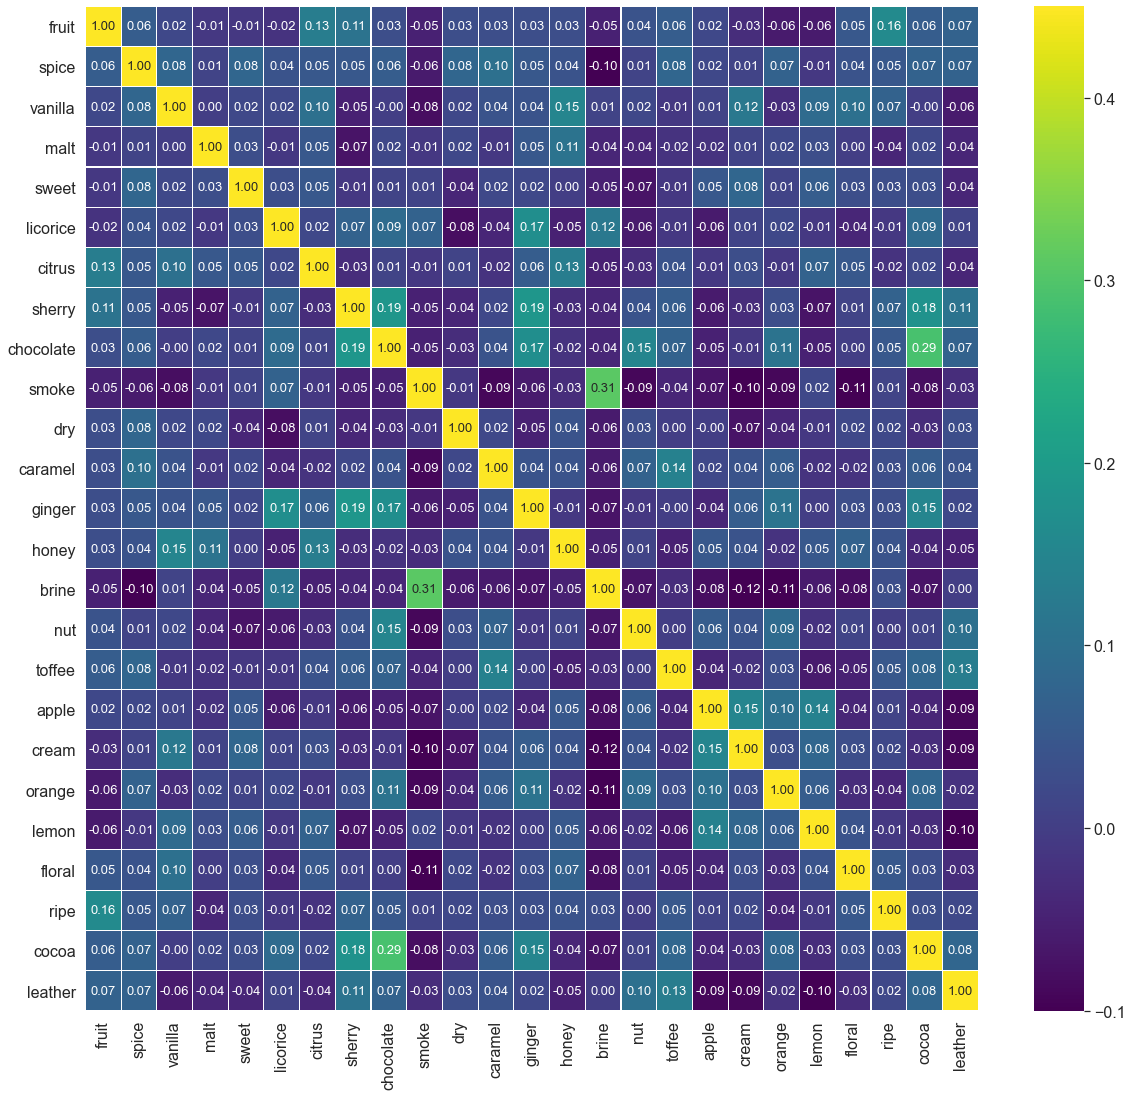

In [59]:
plt.rcParams.update({'font.size': 13})


f, ax = plt.subplots(figsize=(20, 18))
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="viridis",fmt='.2f',
                 linewidths=.05, vmin=-0.1, vmax=.45)
f.subplots_adjust(top=0.9)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
#f.suptitle('Whiskey Freatures Correlation Heatmap', fontsize=18);
f.savefig('heatmap', dpi=700)